In [5]:
from bs4 import BeautifulSoup as BS
import pandas as pd, numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time, re


In [6]:
site_scrapers={
    'target':{
        #specific top-level fields for a product from Target
        'product_data':
            {'product_title':"//h1[@data-test='product-title']",
            #'product_cost':"",
            'product_details':"//div[@data-test='productDetailTabs-itemDetailsTab']",
            'product_specs':"//div[@data-test='item-details-specifications']",
            'product_price':"//span[@class='styles__CurrentPriceFontSize-sc-1mh0sjm-1 kwKAiv']"
            },
# details = driver.find_element(by=By.XPATH,value="//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Details']")
# specs = driver.find_element(by=By.XPATH,value="//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Specifications']")

        #target has dynamic content; this allows us to expand the product details and specifications page
        'product_expand':{
            'product_details':"//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Details']",
            'product_specs':"//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Specifications']"
        },
        #this allows us to navigate within a product page to the reviews and customer feedback
        'navigation':{
            'feedback':"//a[@data-test='ratingCountLink']",
            'reviews':"//button[@data-test='totalReviewLink']",
            'expand':"//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor']" 
        },#styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor
        #these are the items we extract at the top level (e.g. for all reviews summary)
        'review_summary':[
            ('total_star_rating',"//div[@data-test='rating-value']"),
            ('total_star_votes',"//div[@data-test='rating-count']")            
        ],
        #this is the class and style of every block that contains a review
        'review_list':"//div[@class='styles__StyledRow-sc-wmoju4-0 jJAWfL styles__ReviewRow-sc-4u2mi2-1 hmboNn']",
        #this is the data we extract from each review.

        'review_data':{
            'review_header':('h4',{'data-test':'review-card--title'}),
            'reviewer_name':('span',{'data-test':'review-card--username'}),
            'review_content':('div',{'data-test':'review-card--text'}),
            'review_star_rating':('span',{'class':'utils__ScreenReaderOnly-sc-1b93ups-0 hMtWwx'}),
            'review_helpful_votes':('div',{'class':'h-text-sm h-margin-v-tight h-text-grayDark'}),
            'verified_purchaser':('span',{'data-test':'review-card--verified-purchaser'})
        }
    }
}

#provide the list of specific products for which we will scrape data
# target_product_urls = [
# 'https://www.target.com/p/doritos-nacho-cheese-flavored-tortilla-chips-14-5oz/-/A-13319564?ref=tgt_adv_xsp&AFID=google&fndsrc=tgtao&DFA=71700000108139139&CPNG=PLA_Snacks%2BCandy%2BShopping_Local%7CSnacks%2BCandy_Ecomm_Food_Bev&adgroup=SC_Snacks%2BCandy&LID=700000001170770pgs&LNM=PRODUCT_GROUP&network=g&device=c&location=9028882&targetid=pla-566872943420&gad_source=1&gclid=CjwKCAiA_tuuBhAUEiwAvxkgTrVUgEoQxO7gDRv43EXIBS0LKEJIZzesWGUMd9JSJq7OybsxjUxfSxoCYmYQAvD_BwE&gclsrc=aw.ds',
# 'https://www.target.com/p/adjustable-storage-desk-black-room-essentials-8482/-/A-54364953'
# ]

prod_lookups = pd.read_excel('../data/Data Collection.xlsx',sheet_name='productDataCapture')
prod_data = pd.read_excel('../data/Data Collection.xlsx',sheet_name='productCollectionList')
target_product_urls = list(prod_lookups[(prod_lookups['site']=='target')&~(prod_lookups['URL'].isna())]['URL'])
target_product_urls
#open a web browser
# opts = webdriver.EdgeOptions()
# opts.add_argument("--headless=new")
# driver = webdriver.Edge(options=opts)
driver = webdriver.Edge()
action = ActionChains(driver)

In [7]:
target_product_urls= [target_product_urls[-1]]
target_product_urls

['https://www.target.com/p/dyson-ball-animal-3-extra-upright-vacuum/-/A-85269264']

In [8]:
product_records,review_records = [],[]

In [9]:
q = 0

while q <= len(target_product_urls)-1:
    #print(target_product_urls)
    target = target_product_urls[q]
    #print(target)
    curr_product = target #doing this to save time after restructuring code
    #dictionary to store data on the current product
    product_record = {'url':curr_product}
    #navigate to the page
    #UNCOMMENT HERE
    # driver = webdriver.Edge()
    # action = ActionChains(driver)
    driver.get(curr_product)
    #select dynamic fields and expand them for the product
    for k,v in site_scrapers['target']['product_expand'].items():

        try:
            WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                EC.element_to_be_clickable((By.XPATH,v))
            ).click()
        except:
            pass


    #iterate through the fields we want to pull for product data
    for k,v in site_scrapers['target']['product_data'].items():
        try:
            data = driver.find_element(by=By.XPATH,value=v)
            product_record[k] = data.text
        except:
            product_record[k] = None
    #print("finished top level")

    #navigate to the top of the page to find the button we're looking for
    driver.find_element(By.TAG_NAME,value='body').send_keys(Keys.CONTROL+Keys.HOME)

    #navigate to the reviews
    for k,v in site_scrapers['target']['navigation'].items():
        time.sleep(1)
        #print(k,v)
        #print("driver.find_element({})".format(v))
        c=None
        try:
            WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                EC.element_to_be_clickable((By.XPATH,v))
            )
            c=driver.find_element(By.XPATH,value=v)
        except:
            print("couldn't find {}:{}".format(k,v))
            c=None
        # try:
        #     c = driver.find_element(By.XPATH,value=v)
        # except: 
        #     c = None 
        if c is not None:
            if k != 'expand':
                try:
                    WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                        EC.element_to_be_clickable((By.XPATH,v))
                    )
                    c = driver.find_element(By.XPATH,value=v)
                    action.move_to_element(c).perform()
                    c.click()
                except:
                    pass
                #time.sleep(0.5)
            else:
                #pass 
                #get the summarized review data (x.x/5 stars, number of votes)
            ############ UNCOMMENT FROM HERE AND BELOW################
                for r in site_scrapers['target']['review_summary']:
                    try:
                        WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                            EC.visibility_of_element_located((By.XPATH,r[1]))
                        )
                        product_record[r[0]] = driver.find_element(By.XPATH,value=r[1]).text
                    except:
                        product_record[r[0]] = None

                while c is not None:

                    try:
                        WebDriverWait(driver,timeout=8,poll_frequency=0.2).until(
                            EC.visibility_of_element_located((By.XPATH,"//div[@data-test='load-more-btn']"))
                        )
                        elem = driver.find_element(By.XPATH,value="//div[@data-test='load-more-btn']")
                        action.move_to_element(elem).perform()
                        c = driver.find_element(By.XPATH,value="//button[text()='Load ']")
                        #c = driver.find_element(By.XPATH,value=v)
                        action.move_to_element(c).click().perform()
                        #c.click()
                    except:
                        c = None

    product_records.append(product_record)

    review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    #review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    print(len(review_elements))
    for review in review_elements:
        #create a dictionary for the current review
        review_record = {'url':curr_product}
        #beautiful soup seems to work better than selenium for parsing here.
        current = BS(review.get_attribute('innerHTML'))
        for k1,v1 in site_scrapers['target']['review_data'].items():
            if k1 not in ['review_star_rating','review_helpful_votes']:
                val = current.find(v1[0],v1[1])
                if val:
                    review_record[k1] = val.getText()
                else:
                    review_record[k1] = None

            else:
                if k1 == 'review_star_rating':
                    #use regex to find the star rating for the review
                    review_record[k1] = re.findall('(.) ?(?=out of 5 stars)',review.get_attribute('innerHTML'))[0]
                else: 
                    #use regex to get the number of votes that said this one was useful.
                    m = re.findall('([1-9]+) ?(?=guests found)',review.get_attribute('innerHTML'))
                    #sometimes reviews aren't voted as useful.  If they're not, mark them as zero.
                    if m:
                        review_record[k1] = m[0]
                    else:
                        review_record[k1] = 0
        #append the current review to the list of reviews.
        review_records.append(dict.copy(review_record))
    q+=1
    #driver.quit()

99


In [11]:
pd.DataFrame(review_records).to_csv('../data/taget_full_reviews_3.csv')

In [84]:
#prod_lookups = prod_lookups[prod_lookups['site']=='target'].drop(list(range(0,6)))
print(target_product_urls)
target_product_urls = list(prod_lookups[(prod_lookups['site']=='target')&~(prod_lookups['URL'].isna())]['URL'])[2:4]
print(target_product_urls)

['https://www.target.com/p/apple-iphone-14/-/A-87577447', 'https://www.target.com/p/samsung-galaxy-s22-ultra-5g-unlocked-128gb-smartphone-burgundy/-/A-85287714', 'https://www.target.com/p/hp-deskjet-2755e-wireless-all-in-one-color-printer-scanner-copier-with-instant-ink-and-hp-26k67/-/A-82254388', 'https://www.target.com/p/jbl-charge-5-portable-bluetooth-waterproof-speaker-red-target-certified-refurbished/-/A-88249290', 'https://www.target.com/p/microsoft-365-personal-12-month-subscription-digital/-/A-78297146', 'https://www.target.com/p/turbotax-2023-deluxe-federal-and-state-tax-software/-/A-89741680', 'https://www.target.com/p/hamilton-beach-4-slice-toaster-24782/-/A-87232566', 'https://www.target.com/p/razor-24v-mx350-dirt-rocket-electric-powered-ride-on-bike-blue/-/A-53550140', 'https://www.target.com/p/lg-65-34-class-4k-uhd-2160p-smart-oled-tv-oled65c3/-/A-88196023', 'https://www.target.com/p/ge-jes1460dsbb-1-4-cu-ft-black-counter-top-microwave/-/A-90238388', 'https://www.target.c

In [91]:
target_product_urls = [target_product_urls[-1]]
target_product_urls

['https://www.target.com/p/dyson-ball-animal-3-extra-upright-vacuum/-/A-85269264']

In [43]:
#lists to collect records/data for each link
product_records=[]
review_records=[]
#iterate through the target list of products
for target in target_product_urls:
    curr_product = target #doing this to save time after restructuring code
    #dictionary to store data on the current product
    product_record = {'url':curr_product}
    #navigate to the page
    driver.get(curr_product)
    #wait for page to load
    #time.sleep(3)
    #select dynamic fields and expand them for the product
    for k,v in site_scrapers['target']['product_expand'].items():
        #time.sleep(.5)
        #e = None
        WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
            EC.visibility_of_element_located((By.XPATH,v))
        )
        e=driver.find_element(By.XPATH,value=v)
        action.move_to_element(e).perform()
        e=driver.find_element(By.XPATH,value=v)
        e.click()
        # while e is None:

        #     e = driver.find_element(By.XPATH,value=v)
        #     time.sleep(0.1)
        #e.click()

    #iterate through the fields we want to pull for product data
    for k,v in site_scrapers['target']['product_data'].items():
        data = driver.find_element(by=By.XPATH,value=v)
        product_record[k] = data.text
    #print("finished top level")

    #navigate to the top of the page to find the button we're looking for
    driver.find_element(By.TAG_NAME,value='body').send_keys(Keys.CONTROL+Keys.HOME)

    #navigate to the reviews
    for k,v in site_scrapers['target']['navigation'].items():
        time.sleep(1)
        #print(k,v)
        #print("driver.find_element({})".format(v))
        c=None
        try:
            c = driver.find_element(By.XPATH,value=v)
        except: 
            c = None 
        if c is not None:
            if k != 'expand':
                WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                    EC.visibility_of_element_located((By.XPATH,v))
                )
                c = driver.find_element(By.XPATH,value=v)
                action.move_to_element(c).perform()
                c.click()
                #time.sleep(0.5)
            else:
                #get the summarized review data (x.x/5 stars, number of votes)
                for r in site_scrapers['target']['review_summary']:
                    product_record[r[0]] = driver.find_element(By.XPATH,value=r[1]).text
                #expand out to all reviews - keep expanding until we can't.
                while c is not None:
                    #c.click()
                    # WebDriverWait(driver,timeout=8,poll_frequency=0.2).until(
                    #     EC.visibility_of_element_located((By.XPATH,"//div[@data-test='load-more-btn']"))
                    # )
                    # time.sleep(0.5)
                    # elem = driver.find_element(By.XPATH,value="//p[@class='styles__PriceMatchAndStoreInfoFont-sc-1rzhrz1-0 dWMjze']")
                    # action.move_to_element(elem).perform()
                    #time.sleep(1)

                    try:
                        #pass 
                        WebDriverWait(driver,timeout=8,poll_frequency=0.2).until(
                            EC.visibility_of_element_located((By.XPATH,"//div[@data-test='load-more-btn']"))
                        )
                        elem = driver.find_element(By.XPATH,value="//div[@data-test='load-more-btn']")
                        action.move_to_element(elem).perform()
                        c = driver.find_element(By.XPATH,value="//button[text()='Load ']")
                        #c = driver.find_element(By.XPATH,value=v)
                        action.move_to_element(c).click().perform()
                        #c.click()
                    except:
                        c = None
                    # try:
                    # c = driver.find_element(By.XPATH,value=v)
                    #     #c.click()
                    # # except:
                    #     #c = None
                    # if c is not None:
                    #     print(c)
                    #     c.click()

    #append the product record to the list 
    product_records.append(product_record)
    # #build a list of review records.
    # review_records = []

    #get the container that has all the reviews in it
    #review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledRow-sc-wmoju4-0 jJAWfL styles__ReviewRow-sc-4u2mi2-1 hmboNn']")
    #styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width
    review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    #review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    print(len(review_elements))
    for review in review_elements:
        #create a dictionary for the current review
        review_record = {'url':curr_product}
        #beautiful soup seems to work better than selenium for parsing here.
        current = BS(review.get_attribute('innerHTML'))
        for k1,v1 in site_scrapers['target']['review_data'].items(): #my_map.items():#site_scrapers['target']['review_data']:
            if k1 not in ['review_star_rating','review_helpful_votes']:
                val = current.find(v1[0],v1[1])
                if val:
                    review_record[k1] = val.getText()
                else:
                    review_record[k1] = None
                #review_record[k1] = current.find(v1[0],v1[1]).getText()
            else:
                if k1 == 'review_star_rating':
                    #use regex to find the star rating for the review
                    review_record[k1] = re.findall('(.) ?(?=out of 5 stars)',review.get_attribute('innerHTML'))[0]
                else: 
                    #use regex to get the number of votes that said this one was useful.
                    m = re.findall('([1-9]+) ?(?=guests found)',review.get_attribute('innerHTML'))
                    #sometimes reviews aren't voted as useful.  If they're not, mark them as zero.
                    if m:
                        review_record[k1] = m[0]
                    else:
                        review_record[k1] = 0
        #append the current review to the list of reviews.
        review_records.append(dict.copy(review_record))
        #print(review_record)


TimeoutException: Message: 


In [ ]:
product_records=[]
review_records=[]

In [92]:
#lists to collect records/data for each link
# product_records=[]
# review_records=[]
#iterate through the target list of products
#for target in target_product_urls:

q = 0
while q <= len(target_product_urls)-1:
    print(target_product_urls)
    target = target_product_urls[q]
    print(target)
    curr_product = target #doing this to save time after restructuring code
    #dictionary to store data on the current product
    product_record = {'url':curr_product}
    #navigate to the page
    driver = webdriver.Edge()
    action = ActionChains(driver)
    driver.get(curr_product)
    #wait for page to load
    #time.sleep(3)
    #select dynamic fields and expand them for the product
    for k,v in site_scrapers['target']['product_expand'].items():
        #time.sleep(.5)
        #e = None
        try:
            WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                EC.element_to_be_clickable((By.XPATH,v))
            ).click()
        except:
            pass
        # e=driver.find_element(By.XPATH,value=v)
        # action.move_to_element(e).perform()
        # #e=driver.find_element(By.XPATH,value=v)
        # if e and e.is_displayed:
        #     e.click()
        # else:
        #     pass
        # while e is None:

        #     e = driver.find_element(By.XPATH,value=v)
        #     time.sleep(0.1)
        #e.click()

    #iterate through the fields we want to pull for product data
    for k,v in site_scrapers['target']['product_data'].items():
        try:
            data = driver.find_element(by=By.XPATH,value=v)
            product_record[k] = data.text
        except:
            product_record[k] = None
    #print("finished top level")

    #navigate to the top of the page to find the button we're looking for
    driver.find_element(By.TAG_NAME,value='body').send_keys(Keys.CONTROL+Keys.HOME)

    #navigate to the reviews
    for k,v in site_scrapers['target']['navigation'].items():
        time.sleep(1)
        #print(k,v)
        #print("driver.find_element({})".format(v))
        c=None
        try:
            WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                EC.element_to_be_clickable((By.XPATH,v))
            )
            c=driver.find_element(By.XPATH,value=v)
        except:
            print("couldn't find {}:{}".format(k,v))
            c=None
        # try:
        #     c = driver.find_element(By.XPATH,value=v)
        # except: 
        #     c = None 
        if c is not None:
            if k != 'expand':
                try:
                    WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                        EC.element_to_be_clickable((By.XPATH,v))
                    )
                    c = driver.find_element(By.XPATH,value=v)
                    action.move_to_element(c).perform()
                    c.click()
                except:
                    pass
                #time.sleep(0.5)
            else:
                #get the summarized review data (x.x/5 stars, number of votes)
                for r in site_scrapers['target']['review_summary']:
                    try:
                        WebDriverWait(driver,timeout=5,poll_frequency=0.1).until(
                            EC.visibility_of_element_located((By.XPATH,r[1]))
                        )
                        product_record[r[0]] = driver.find_element(By.XPATH,value=r[1]).text
                    except:
                        product_record[r[0]] = None
                #expand out to all reviews - keep expanding until we can't.
                while c is not None:
                    #c.click()
                    # WebDriverWait(driver,timeout=8,poll_frequency=0.2).until(
                    #     EC.visibility_of_element_located((By.XPATH,"//div[@data-test='load-more-btn']"))
                    # )
                    # time.sleep(0.5)
                    # elem = driver.find_element(By.XPATH,value="//p[@class='styles__PriceMatchAndStoreInfoFont-sc-1rzhrz1-0 dWMjze']")
                    # action.move_to_element(elem).perform()
                    #time.sleep(1)

                    try:
                        #pass 
                        WebDriverWait(driver,timeout=8,poll_frequency=0.2).until(
                            EC.visibility_of_element_located((By.XPATH,"//div[@data-test='load-more-btn']"))
                        )
                        elem = driver.find_element(By.XPATH,value="//div[@data-test='load-more-btn']")
                        action.move_to_element(elem).perform()
                        c = driver.find_element(By.XPATH,value="//button[text()='Load ']")
                        #c = driver.find_element(By.XPATH,value=v)
                        action.move_to_element(c).click().perform()
                        #c.click()
                    except:
                        c = None
                    # try:
                    # c = driver.find_element(By.XPATH,value=v)
                    #     #c.click()
                    # # except:
                    #     #c = None
                    # if c is not None:
                    #     print(c)
                    #     c.click()

    #append the product record to the list 
    product_records.append(product_record)
    # #build a list of review records.
    # review_records = []

    #get the container that has all the reviews in it
    #review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledRow-sc-wmoju4-0 jJAWfL styles__ReviewRow-sc-4u2mi2-1 hmboNn']")
    #styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width
    review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    #review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    print(len(review_elements))
    for review in review_elements:
        #create a dictionary for the current review
        review_record = {'url':curr_product}
        #beautiful soup seems to work better than selenium for parsing here.
        current = BS(review.get_attribute('innerHTML'))
        for k1,v1 in site_scrapers['target']['review_data'].items(): #my_map.items():#site_scrapers['target']['review_data']:
            if k1 not in ['review_star_rating','review_helpful_votes']:
                val = current.find(v1[0],v1[1])
                if val:
                    review_record[k1] = val.getText()
                else:
                    review_record[k1] = None
                #review_record[k1] = current.find(v1[0],v1[1]).getText()
            else:
                if k1 == 'review_star_rating':
                    #use regex to find the star rating for the review
                    review_record[k1] = re.findall('(.) ?(?=out of 5 stars)',review.get_attribute('innerHTML'))[0]
                else: 
                    #use regex to get the number of votes that said this one was useful.
                    m = re.findall('([1-9]+) ?(?=guests found)',review.get_attribute('innerHTML'))
                    #sometimes reviews aren't voted as useful.  If they're not, mark them as zero.
                    if m:
                        review_record[k1] = m[0]
                    else:
                        review_record[k1] = 0
        #append the current review to the list of reviews.
        review_records.append(dict.copy(review_record))
        #print(review_record)

    q+=1
    driver.quit()

['https://www.target.com/p/dyson-ball-animal-3-extra-upright-vacuum/-/A-85269264']
https://www.target.com/p/dyson-ball-animal-3-extra-upright-vacuum/-/A-85269264
99


In [95]:
revs = pd.DataFrame(review_records)
revs['url'].unique()
p = pd.DataFrame(product_records)
display(
    p['url'].unique(),revs['url'].unique())

array(['https://www.target.com/p/apple-iphone-14/-/A-87577447',
       'https://www.target.com/p/samsung-galaxy-s22-ultra-5g-unlocked-128gb-smartphone-burgundy/-/A-85287714',
       'https://www.target.com/p/hp-deskjet-2755e-wireless-all-in-one-color-printer-scanner-copier-with-instant-ink-and-hp-26k67/-/A-82254388',
       'https://www.target.com/p/dyson-ball-animal-3-extra-upright-vacuum/-/A-85269264'],
      dtype=object)

array(['https://www.target.com/p/apple-iphone-14/-/A-87577447',
       'https://www.target.com/p/samsung-galaxy-s22-ultra-5g-unlocked-128gb-smartphone-burgundy/-/A-85287714',
       'https://www.target.com/p/hp-deskjet-2755e-wireless-all-in-one-color-printer-scanner-copier-with-instant-ink-and-hp-26k67/-/A-82254388',
       'https://www.target.com/p/dyson-ball-animal-3-extra-upright-vacuum/-/A-85269264'],
      dtype=object)

In [96]:
full_target_revs1 = pd.DataFrame(review_records)
full_target_prods1 = pd.DataFrame(product_records)
full_target_revs1.to_csv('../data/target_full_reviews_2.csv')
full_target_prods1.to_csv('../data/target_full_prods_2.csv')

In [52]:
#elem = driver.find_element(By.XPATH,value="//div[@data-test='load-more-btn']")
driver.find_element(By.TAG_NAME,'body').send_keys(Keys.CONTROL+Keys.END)
try:
    driver.find_element(By.XPATH,value="//div[@data-test='load-more-btn']")
except:
    print("button doesn't exist")

button doesn't exist


In [33]:
len(review_records)
# c = driver.find_element(By.XPATH,value="//button[text()='Load ']")
# c.click()
review_records_back = review_records.copy()
review_records_back
review_records_back2 = review_records.copy()

display(review_records_back,review_records_back2)

In [37]:
review_records_back2 = review_records.copy()

display(review_records_back,review_records_back2)

[{'url': 'https://www.target.com/p/apple-iphone-14/-/A-87577447',
  'review_header': 'Help with the nightmare situation.',
  'reviewer_name': 'J Fosko',
  'review_content': 'When I got the phone we did not want the phone number.the original account was canceled at an ATT store.',
  'review_star_rating': '3',
  'review_helpful_votes': 0,
  'verified_purchaser': None},
 {'url': 'https://www.target.com/p/apple-iphone-14/-/A-87577447',
  'review_header': 'Loving it!',
  'reviewer_name': 'Nanner74',
  'review_content': 'I am new to iPhones but I am loving the easy using of one. I love the storage of this phone then one on a Samsung where I used a memory card for my pictures. I hope I have enough room on this one for a lot of pictures.',
  'review_star_rating': '5',
  'review_helpful_votes': 0,
  'verified_purchaser': None},
 {'url': 'https://www.target.com/p/apple-iphone-14/-/A-87577447',
  'review_header': 'Nice phone',
  'reviewer_name': 'Brandi R',
  'review_content': 'My daughter really

[{'url': 'https://www.target.com/p/apple-iphone-14/-/A-87577447',
  'review_header': 'Help with the nightmare situation.',
  'reviewer_name': 'J Fosko',
  'review_content': 'When I got the phone we did not want the phone number.the original account was canceled at an ATT store.',
  'review_star_rating': '3',
  'review_helpful_votes': 0,
  'verified_purchaser': None},
 {'url': 'https://www.target.com/p/apple-iphone-14/-/A-87577447',
  'review_header': 'Loving it!',
  'reviewer_name': 'Nanner74',
  'review_content': 'I am new to iPhones but I am loving the easy using of one. I love the storage of this phone then one on a Samsung where I used a memory card for my pictures. I hope I have enough room on this one for a lot of pictures.',
  'review_star_rating': '5',
  'review_helpful_votes': 0,
  'verified_purchaser': None},
 {'url': 'https://www.target.com/p/apple-iphone-14/-/A-87577447',
  'review_header': 'Nice phone',
  'reviewer_name': 'Brandi R',
  'review_content': 'My daughter really

In [16]:
more_reviews = pd.DataFrame(review_records)
more_reviews

import numpy as np
cases = [more_reviews['verified_purchaser'].isna(), ~more_reviews['verified_purchaser'].isna()]
results = [False,True]
more_reviews['verified_purchaser'] = np.select(cases,results)
more_reviews
more_reviews.to_csv('../data/target_partial_data10.csv')

In [74]:
from selenium.webdriver.common.action_chains import ActionChains
c = driver.find_element(By.XPATH,value="//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor']")
action = ActionChains(driver)
action.move_to_element(c).click().perform()
#print(c)
#c.click()
#help(action)
# html = driver.find_element(By.TAG_NAME,value='body')
# html.send_keys(Keys.PAGE_DOWN)
# html.send_keys(Keys.PAGE_DOWN)
# html.send_keys(Keys.PAGE_DOWN)

In [39]:
driver.find_element(By.XPATH,"//span[@class='styles__CurrentPriceFontSize-sc-1mh0sjm-1 kwKAiv']")

<selenium.webdriver.remote.webelement.WebElement (session="caa0eac940af8504904ed0483db8885e", element="f.91EEA61DA9524E5B662CE84FD8FA1458.d.0A549A66DBBE800BA0DA887BCE0A0E48.e.287")>

In [ ]:
review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
review_elements

[<selenium.webdriver.remote.webelement.WebElement (session="4b58147b3c89907723f14fea0120b527", element="f.2F55958910D55C70BB143C71865E3712.d.3EE59C130DEC98D848E08B20348D2BE2.e.7094")>]

In [ ]:
x = BS(review_elements[4].get_attribute('innerHTML')).find('span',{'data-test':'review-card--verified-purchaser'})
if x:
    print("verified")
else:
    print("not")

not


In [ ]:
products = pd.DataFrame(product_records)
reviews = pd.DataFrame(review_records)
#products.to_csv('../data/target_products.csv',index=False)
#reviews.to_csv('../data/target_reviews.csv',index=False)

In [ ]:
products.iloc[0]['url']

'https://www.target.com/p/apple-iphone-14/-/A-87577447'

In [ ]:
len(review_records)

0

In [ ]:
len(reviews)
#reviews = pd.read_csv('../data/target_reviews.csv')

3416

In [ ]:
reviews.head()

""


In [ ]:
import pandas as pd, numpy as np
reviews = pd.read_csv('../data/target_reviews.csv')
products = pd.read_csv('../data/target_products.csv')

# from nltk.classify import NaiveBayesClassifier
# from nltk.corpus import subjectivity
# from nltk.sentiment import SentimentAnalyzer
# from nltk.sentiment.util import *
from nltk.corpus import stopwords

In [ ]:
import textblob
test_blob = textblob.TextBlob(products.loc[0]['product_details'])

In [ ]:
products['description_subjectivity'] = None

In [ ]:
stop = set(stopwords.words("english"))
for i,row in products.iterrows():
    blob = textblob.TextBlob(row['product_details'] + "\n" + row['product_specs'])
    # tokens = set(blob.words)
    # blob = textblob.TextBlob(''.join(tokens-stop))
    subj = blob.subjectivity
    #print(subj)
    row['description_subjectivity'] = float(subj)
    products.loc[i] = row

#products
    
products['total_star_votes'] = products['total_star_votes'].str.replace(' star ratings','')
products['total_star_votes'] = products['total_star_votes'].astype(float)
products

products['product_price'] = products['product_price'].str.replace('\$|,','',regex=True)

#products['product_price'] = products['product_price'].str.replace('Price Varies','1100')#,regex=True)
#products[products['product_price']=='Price Varies']['product_price'] = 0
#products['product_price'] = products['product_price'].astype(float)


In [ ]:
products.info()
products['description_subjectivity'] = products['description_subjectivity'].astype(float)
products.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       14 non-null     object 
 1   product_title             14 non-null     object 
 2   product_details           14 non-null     object 
 3   product_specs             14 non-null     object 
 4   product_price             14 non-null     object 
 5   total_star_rating         11 non-null     float64
 6   total_star_votes          11 non-null     float64
 7   description_subjectivity  14 non-null     object 
dtypes: float64(2), object(6)
memory usage: 1.0+ KB


,count,mean,std,min,25%,50%,75%,max
total_star_rating,11.0,4.327273,0.531208,3.000000,4.250000,4.400000,4.700000,4.800000
total_star_votes,11.0,3055.272727,3593.350890,26.000000,438.000000,1642.000000,4326.000000,10794.000000
description_subjectivity,14.0,0.499391,0.106496,0.290826,0.440831,0.507963,0.548835,0.681818


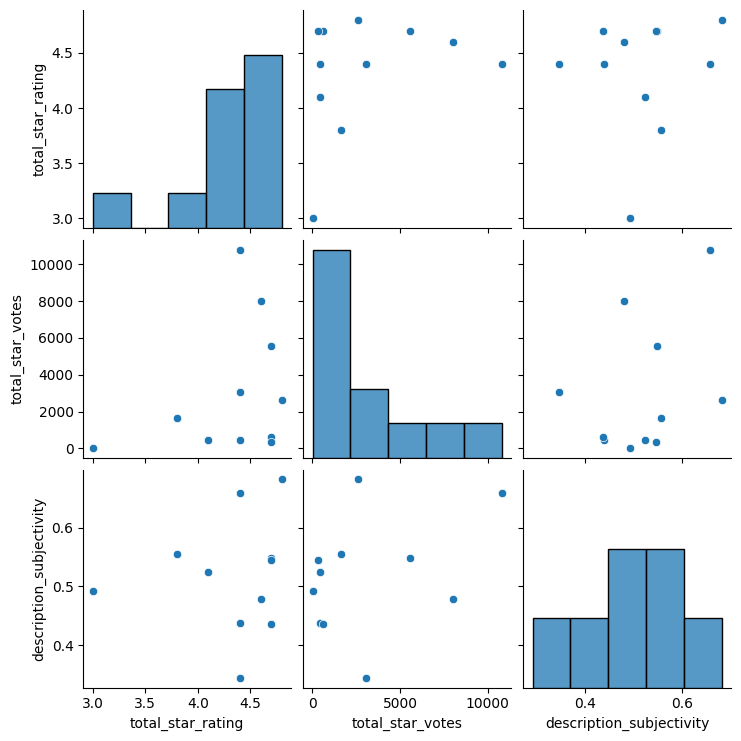

In [ ]:
import seaborn as sns
sns.pairplot(
    data=products
)

In [ ]:
reviews[['review_subjectivity','review_polarity']] = None,None
for i,row in reviews.iterrows():
    #include the header in the summary
    #s = row['review_header'] + row['review_content']
    blob = textblob.TextBlob(row['review_content'])
    row[['review_subjectivity','review_polarity']] = float(blob.subjectivity),float(blob.polarity)
    reviews.loc[i] = row



In [ ]:
reviews['review_length'] = reviews['review_content'].str.len()

reviews

,url,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchaser,review_subjectivity,review_polarity,review_length
0,https://www.target.com/p/apple-iphone-14/-/A-8...,Help with the nightmare situation.,J Fosko,When I got the phone we did not want the phone...,3,0,NaN,0.75,0.375,104
1,https://www.target.com/p/apple-iphone-14/-/A-8...,Loving it!,Nanner74,I am new to iPhones but I am loving the easy u...,5,0,NaN,0.667576,0.333939,218
2,https://www.target.com/p/apple-iphone-14/-/A-8...,Nice phone,Brandi R,My daughter really likes her new phone.,5,0,NaN,0.327273,0.168182,39
3,https://www.target.com/p/apple-iphone-14/-/A-8...,Apple Iphone 14 purchase,Larry Justin,The Apple Iphone 14 is well worth the price. E...,5,0,NaN,0.39697,0.242424,83
4,https://www.target.com/p/apple-iphone-14/-/A-8...,Happy,Momo3boys,It’s pretty good no different then the 13,5,0,NaN,0.733333,0.316667,41
...,...,...,...,...,...,...,...,...,...,...
3411,https://www.target.com/p/crest-cavity-38-tarta...,Great job on teeth,Shelley310,Great product. Makes teeth and mouth feel grea...,5,0,NaN,0.56,0.56,112
3412,https://www.target.com/p/crest-cavity-38-tarta...,Exactly what I want,Ginger628,This product is great and does everything I ne...,5,0,NaN,0.75,0.8,57
3413,https://www.target.com/p/crest-cavity-38-tarta...,Perfect,Michy,"I highly recommend this toothpaste , makes my ...",5,0,NaN,0.601667,0.29,78
3414,https://www.target.com/p/crest-cavity-38-tarta...,great product,Lgreco,we love this product make our teeth feel great...,5,0,NaN,0.6375,0.541667,104


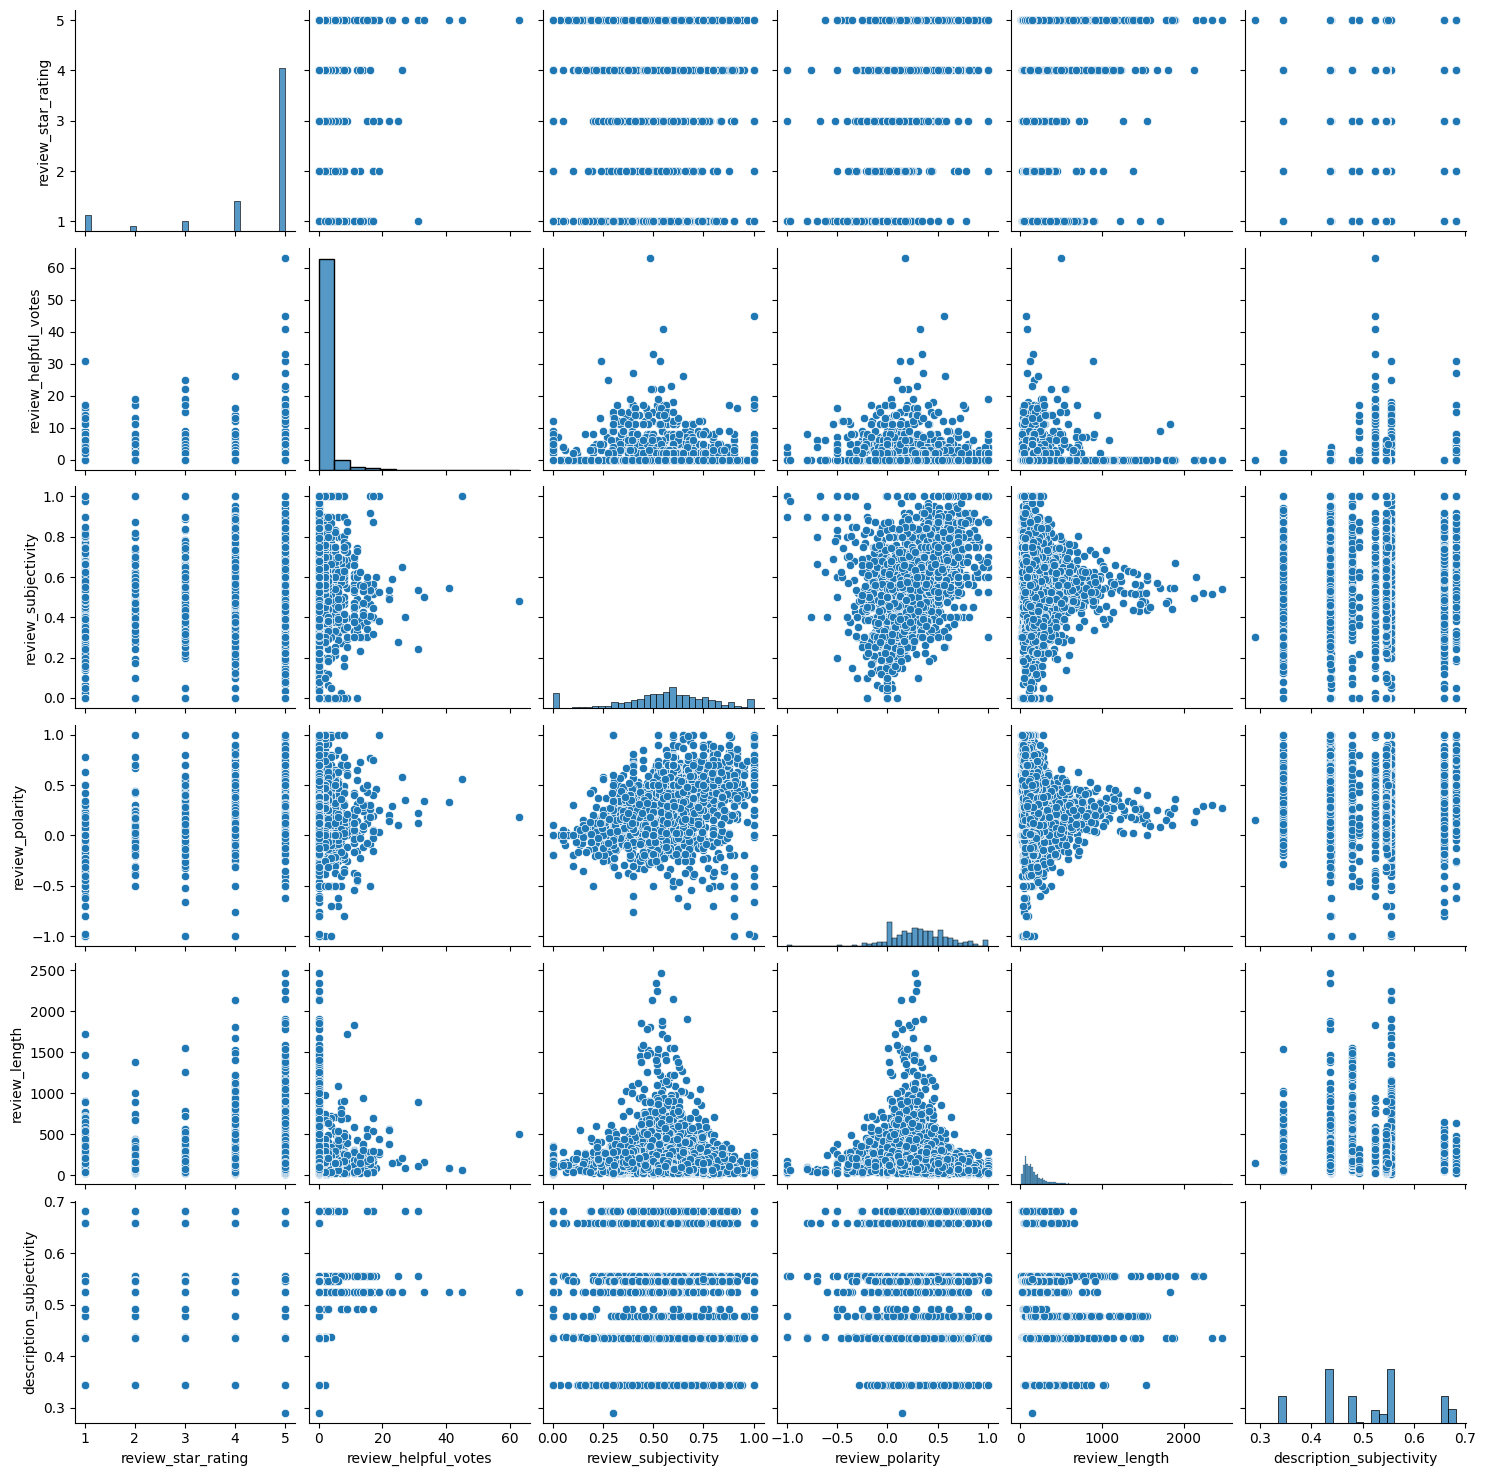

In [ ]:
merged = reviews.merge(right=products[['url','description_subjectivity']],how='left',on='url')
sns.pairplot(
    merged    
)

In [ ]:
x = reviews.groupby('url',as_index=False).agg({
    'review_helpful_votes':'mean',
    'review_subjectivity':'mean',
    'review_polarity':'mean',
    'review_length':'mean'
}
)

x.merge(right=products,how='left',on='url')[
    ['product_title','url','review_helpful_votes','review_subjectivity',
     'review_polarity','review_length','description_subjectivity','total_star_rating'
     ]
]

,product_title,url,review_helpful_votes,review_subjectivity,review_polarity,review_length,description_subjectivity,total_star_rating
0,Apple iPhone 14,https://www.target.com/p/apple-iphone-14/-/A-8...,0.031863,0.57894,0.335787,96.058824,0.437937,4.4
1,"Crest Cavity & Tartar Protection Toothpaste, B...",https://www.target.com/p/crest-cavity-38-tarta...,0.532847,0.547487,0.293993,174.978102,0.545629,4.7
2,Doritos Nacho Cheese Flavored Tortilla Chips -...,https://www.target.com/p/doritos-nacho-cheese-...,1.938095,0.551695,0.393941,74.252381,0.681818,4.8
3,GE JES1460DSBB 1.4 Cu. Ft. Black Counter Top M...,https://www.target.com/p/ge-jes1460dsbb-1-4-cu...,0.019608,0.518098,0.287269,176.698529,0.344769,4.4
4,HP DeskJet 2755e Wireless All-In-One Color Pri...,https://www.target.com/p/hp-deskjet-2755e-wire...,2.259804,0.581468,0.222523,302.210784,0.555611,3.8
5,JBL Charge 5 Portable Bluetooth Waterproof Spe...,https://www.target.com/p/jbl-charge-5-portable...,0.000000,0.3,0.15,148.000000,0.290826,NaN
6,"LG 65"" Class 4K UHD 2160p Smart OLED TV - OLED...",https://www.target.com/p/lg-65-34-class-4k-uhd...,0.029412,0.617655,0.393312,258.061275,0.435398,4.7
7,Microsoft 365 Personal 12-Month Subscription (...,https://www.target.com/p/microsoft-365-persona...,6.200000,0.614028,0.144092,124.066667,0.492037,3.0
8,OXO POP 3pc Plastic Food Storage Container Set...,https://www.target.com/p/oxo-pop-3pc-plastic-f...,5.000000,0.75,0.5,146.000000,0.549213,NaN
9,Razor 24V MX350 Dirt Rocket Electric Powered R...,https://www.target.com/p/razor-24v-mx350-dirt-...,7.607143,0.490321,0.25093,195.403061,0.523889,4.1


In [ ]:
reviews.info()
reviews['review_polarity'] = reviews['review_polarity'].astype(float)
reviews['review_subjectivity'] = reviews['review_subjectivity'].astype(float)
reviews.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   url                   3416 non-null   object
 1   review_header         3414 non-null   object
 2   reviewer_name         3257 non-null   object
 3   review_content        3416 non-null   object
 4   review_star_rating    3416 non-null   int64 
 5   review_helpful_votes  3416 non-null   int64 
 6   verified_purchaser    374 non-null    object
 7   review_subjectivity   3416 non-null   object
 8   review_polarity       3416 non-null   object
 9   review_length         3416 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 267.0+ KB


,count,mean,std,min,25%,50%,75%,max
review_star_rating,3416.0,4.406030,1.167625,1.0,4.0000,5.000000,5.0,5.0
review_helpful_votes,3416.0,0.885246,3.163713,0.0,0.0000,0.000000,0.0,63.0
review_subjectivity,3416.0,0.556650,0.233181,0.0,0.4500,0.578619,0.7,1.0
review_polarity,3416.0,0.308787,0.296761,-1.0,0.1141,0.311111,0.5,1.0
review_length,3416.0,198.348361,231.562732,10.0,71.0000,129.500000,230.0,2467.0


reviews['']

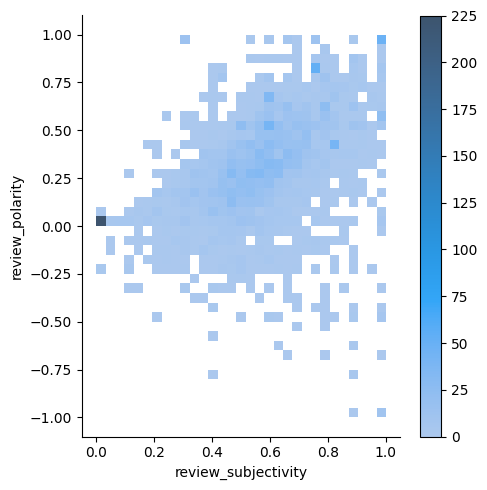

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns 

sns.displot(
    data=reviews,
    x='review_subjectivity',y='review_polarity',cbar=True
)


Looks like the review subjectivity and objectivity intersection is where it's neutral polarity and not subjective.  Doesn't seem to be a strong correlation beetween subjectivity and polarity just on glance.

In [ ]:
subj_docs = [(sent,'subj') for sent in subjectivity.sents(categories='subj')]
obj_docs = []